# Notes

I have tried solving the problem as is, it seems to suffer and I'm struggling to adequaltely shape a valuable reward signal

I am going to try to bring in the idea of "levels", such that I provide increasingly harder versions of the problem up to the actual problem, and it will learn to beat these levels over time.

Early Stopping once goal is reached:

- Implement done condition for objective being reached, any points attained afterwards are outside of achieving the base goal of filling up category requirements

Levels vs No levels:
- With levels, model seems to learn to reject at higher rates
- With no level, model seems to rely on keeping rejections low

Incremental goal achievements as levels:
- Provide sparse "goal" completion rewards as model fills categories

# Installs and Imports

In [ ]:
%%capture
!pip install stable-baselines3[extra] optuna

In [ ]:
#imports

# gym stuff
import gymnasium
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

# helpers
import numpy as np
import random
from IPython.display import clear_output
import os
import copy

# stable baselines stuff
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_util import make_vec_env

# import pandas
import pandas as pd

# typing
from typing import Optional, Union, Any

# visualizations
import matplotlib.pyplot as plt

# optuna for hyperparameter search
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

# torch stuff for optuna
import torch
import torch.nn as nn

# synthetic df creation stuff
from scipy.stats import norm
from scipy.linalg import cholesky

# Synthetic Data Gaussian Copula

In [ ]:
def generate_correlated_data(
    relative_frequencies,
    target_correlation_matrix,
    num_samples,
    categories
  ):
  """
  Generates synthetic binary data with specified marginal probabilities
  and correlation matrix using a Gaussian copula.

  Args:
      marginal_probabilities (list): A list of length n containing the
                                      probability of a '1' for each binary variable.
      target_correlation_matrix (np.ndarray): The nxn target correlation matrix.
      num_samples (int): The number of synthetic samples to generate.

  Returns:
      pd.DataFrame: A DataFrame containing the synthetic binary data.
  """
  n_vars = len(relative_frequencies)

  # Step 1: Ensure the correlation matrix is positive semi-definite
  # This is important for the Cholesky decomposition
  try:
    # to induce the desired correlations, monte carlo simulations
    cholesky_matrix = np.linalg.cholesky(target_correlation_matrix)

  except np.linalg.LinAlgError:
    print("Warning: Correlation matrix is not positive semi-definite. "
              "Adjusting eigenvalues to make it valid.")
    # Make the matrix positive semi-definite by adjusting eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(target_correlation_matrix)
    eigenvalues[eigenvalues < 0] = 1e-6  # Replace negative eigenvalues with a small positive value
    valid_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    cholesky_matrix = np.linalg.cholesky(valid_matrix)

  # Step 2: Generate uncorrelated standard normal variables
  uncorrelated_normal = norm.rvs(size=(num_samples, n_vars))

  # Step 3: Create correlated normal variables using Cholesky decomposition
  correlated_normal = np.dot(uncorrelated_normal, np.transpose(cholesky_matrix))

  # Step 4: Convert correlated normals to uniformly distributed data
  # This is an inverse-transform
  # Go from samples from from normal to samples drawn from desired target distribution
  correlated_uniform = norm.cdf(correlated_normal)

  # Step 5: Transform uniforms to binary outcomes using marginal probabilities
  return pd.DataFrame((correlated_uniform < relative_frequencies).astype(int))

## Useful Globals

## scenario 2

In [ ]:
corr = [
    [1.0, -0.469616933267432, 0.0946331703989159, -0.654940381560618],
    [-0.469616933267432, 1.0, 0.141972591404715, 0.572406780843645],
    [0.0946331703989159, 0.141972591404715, 1.0, 0.144464595056508],
    [-0.654940381560618, 0.572406780843645, 0.144464595056508, 1.0]
]

relative_frequencies = [0.6265, 0.47, 0.06227, 0.398]
cat_mins = [650, 450, 300, 750]
categories = ["tl", "wc", "c", "bl"]

rel_freq_dict = {cat: freq for cat, freq in zip(categories, relative_frequencies)}

num_samples = 1000000

## scenario 3

In [ ]:
corr = [
    [1.0, -0.0811, -0.1697, 0.0372, 0.0722, 0.112],
    [-0.0811, 1.0, 0.376, 0.00367, -0.0308, -0.717],
    [-0.1697, 0.376, 1.0, -0.00345, -0.110, -0.352],
    [0.0372, 0.00367, -0.00345, 1.0, 0.4799, 0.04797],
    [0.0722, -0.0308, -0.110, 0.4799, 1.0, 0.0998],
    [0.112, -0.717, -0.352, 0.04797, 0.0998, 1.0]
]

relative_frequencies = [
    0.68,
    0.5735,
    0.69,
    0.046,
    0.0445,
    0.457
]

cat_mins = [
    500,
    650,
    550,
    250,
    200,
    800
]

categories = [
    'uv',
    'i',
    'ff',
    'qf',
    'vc',
    'gs'
]

cat_to_min = {cat: min for cat, min in zip(categories, cat_mins)}
cat_to_rel_freq = {cat: freq for cat, freq in zip(categories, relative_frequencies)}

rel_freq_dict = {cat: freq for cat, freq in zip(categories, relative_frequencies)}

num_samples = 1000000

In [ ]:
# Define desired relative frequencies (proportions)
desired_proportions = np.array(relative_frequencies)

# Define the target correlation matrix
# Note: This matrix must be valid and result in a positive semi-definite latent matrix.
target_correlation = np.array(corr)

# Generate the data
synthetic_df = generate_correlated_data(desired_proportions, target_correlation, num_samples, len(cat_mins))

if synthetic_df is not None:
    print("Synthetic Binary Data Shape:", synthetic_df.shape)

    # Verify results (optional)
    print("\nEmpirical Proportions:")
    print(synthetic_df.mean(axis=0))

    print("\nEmpirical Correlation Matrix:")
    empirical_corr = np.corrcoef(synthetic_df, rowvar=False)
    print(np.round(empirical_corr, 2))

Synthetic Binary Data Shape: (1000000, 6)

Empirical Proportions:
0    0.679646
1    0.573291
2    0.689692
3    0.046107
4    0.044674
5    0.457770
dtype: float64

Empirical Correlation Matrix:
[[ 1.   -0.05 -0.1   0.01  0.02  0.07]
 [-0.05  1.    0.24  0.   -0.01 -0.51]
 [-0.1   0.24  1.   -0.   -0.04 -0.22]
 [ 0.01  0.   -0.    1.    0.19  0.02]
 [ 0.02 -0.01 -0.04  0.19  1.    0.04]
 [ 0.07 -0.51 -0.22  0.02  0.04  1.  ]]


# Environment 1

In [ ]:
class BouncerEnv(Env):
  def __init__(self, df: pd.DataFrame, num_cats: int, rel_freqs: list, cat_mins: list, max_accepted: int, max_rejected: int):
    # useful vars
    self.num_cats = num_cats
    self.rel_freqs = rel_freqs
    self.max_freq_reward =  sum([1 / i for i in self.rel_freqs])
    self.last_p_tot_left = 1.0
    # Actions we can take, accept or reject
    self.action_space = Discrete(2, start=0)
    # Subgroup categories of sample, cats_accepted, accepted and rejected
    self.observation_space = Dict(
        {
          "cur_sample": MultiBinary(num_cats),
          # The upper bounds for MultiDiscrete should be inclusive, hence + 1
          "cats_accepted": MultiDiscrete([max_accepted + 1 for i in range(num_cats)]),
          "accepted": Discrete(max_accepted + 1),
          "rejected": Discrete(max_rejected + 1)
          })
    # get first sample to initialize states
    first_sample = np.array(df.iloc[0], dtype = np.int8)
    # Set starting state, from first sample
    self.state = {
        "cur_sample": first_sample,
        "cats_accepted": np.array([0]*num_cats),
        "accepted": 0,
        "rejected": 0
    }
    # mins and maxes
    self.cat_mins = cat_mins
    self.max_accepted = max_accepted
    self.max_rejected = max_rejected

    # df, sample and sample index
    self.df = df
    self.cur_sample_idx = 0

  def update_p_tot_left(self):
    self.last_p_tot_left = 1.0 - self.state["accepted"] / self.max_accepted

  def req_satisfied(self):
    if all(self.state["cats_accepted"][i] >= self.cat_mins[i] for i in range(self.num_cats)):
      return True
    return False

  def next_sample(self):
    self.cur_sample_idx += 1
    return np.array(self.df.iloc[self.cur_sample_idx], dtype = np.int8)

  def calc_reward(self, cur_sample):
    """
    This reward will be negated upon rejection, as rejection rewards mirror acceptance rewards

    Due to the summation of rewards, the negation of this summation will imply any rewards
    from acceptance will become penalties for a rejection, and vice versa.

    Ex: Accept reward = 1 for rarity acceptance + 3 for req fulfillment
        Reject reward = -1 for rarity rejection - 3 for req unfulfillment

        When no categories are met:

        Accept reward = -5 for not being selective
        Reject reward = 5 for being selective

    This will all depend on if requirements have been met, as we wish to be selective
    """
    # dynamic acceptance policy based on categorical rareness and approaching the goal
    # reward = 0
    # # will scale gains by rarity of category being accepted
    # for cat in range(self.num_cats):
    #   if cur_sample[cat] == 1:
    #     cur_reward = 0
    #     # # scale acceptance reward by rarity, pushing it to learn to prioritize by rarity
    #     # cur_reward += (1 - self.rel_freqs[cat])
    #     # prioritize acceptance by percentage needed
    #     # From 1 -> -1, decreasing overtime from 1 -> 0 until fulfillment, then from 0 -> -1 once overpopulation begins
    #     cur_reward += (self.cat_mins[cat] - self.state["cats_accepted"][cat]) / self.cat_mins[cat]
    #     """
    #     ensure reward reflects need to fulfill spots
    #     if lots of spots to fill, accepting is good
    #     accepting becomes less good as spots fill
    #     """
    #     reward += cur_reward

    # # selectiveness mechanism, without this it will focus on accepting everybody who fulfills a category
    # # TODO

    # """
    # End-game selectiveness criteria, toss all [0]*cat_nums while requirement not met

    # Accept anybody once requirement met
    # """
    # if reward == 0 and self.req_satisfied():
    #   reward = 10
    # elif reward == 0:
    #   reward = -10

    # reward if acceptance rates for categories similar to total capacity fulfillment rate
    # will fail towards the end
    # need to ensure p_tot_left rises
    """
    This does two things:

    1) Nudges model to accept
    2) Nudges model to accept categorical attributes at similar rate to total capacity

    Based on my tests, this seems optimal for solving the problem

    Category rates are capped by acceptance rates... Would need to rephrase problem to optimize further
    """
    reward = 0
    cur_p_tot_left = 1.0 - (self.state["accepted"] / self.max_accepted)
    if cur_p_tot_left < self.last_p_tot_left:
      p_tot_left = [1 - (self.state["accepted"] / self.max_accepted)] * self.num_cats
      p_cats_left = []
      for cat in range(self.num_cats):
        p_cats_left.append(1 - (self.state["cats_accepted"][cat]) / self.cat_mins[cat])

      if np.allclose(p_tot_left, p_cats_left, atol=5):
        reward = 1
      else:
        reward = -1

    return reward

  def step(self, action: bool):
    accepted = action
    cur_sample = np.array(self.df.iloc[self.cur_sample_idx], dtype=np.int8)
    if accepted:
      # increment corresponding groups, ensuring no out of bounds actions result since these aren't relevant
      for i in range(self.num_cats):
        sample_is_cat_i = cur_sample[i]
        if sample_is_cat_i:
          self.state["cats_accepted"][i] += 1
      # increment total accepted
      self.state["accepted"] += 1
    # rejected, increment rejections
    else:
      self.state["rejected"] += 1

    # sample next person in line
    self.state["cur_sample"] = self.next_sample()

    # calculate reward
    reward = self.calc_reward(cur_sample)

    # check termination conditions
    done = False
    truncated = False

    # 1) filled 1000
    if self.state["accepted"] >= self.max_accepted:
      done = True
    # 2) rejected 4000, leaderboard stats
    elif self.state["rejected"] >= 4000:
      done = True
      truncated = True
    # 3) not enough spots remaining
    elif any([(self.cat_mins[i] - self.state["cats_accepted"][i]) > (1000 - self.state["accepted"]) for i in range(self.num_cats)]):
      done = True
      truncated = True
    # 4) keep going
    else:
      done = False

    if done and not self.req_satisfied():
      reward -= -1

    # truncated, not relevant here due to no timelimit and not being able to go out of bounds
    truncated = False

    # injection of random noise
    # unsure how to do this, but may aid in stability of training the model, like diffusion models learning a vector space

    # Placeholder for info
    info = {}

    # update last_p_tot_left
    self.update_p_tot_left()

    return self.state, reward, done, truncated, info

  def render(self):
    # visualizations
    pass

  def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> tuple[dict[str, np.ndarray], dict]:
    # reset environment

    # shuffle dataset and get first in line
    self.df = self.df.sample(frac=1).reset_index(drop=True) # Reshuffle and reset index
    self.cur_sample_idx = 0
    first_sample = np.array(self.df.iloc[0], dtype = np.int8)
    # sample first state
    self.state = {
        "cur_sample": first_sample,
        "cats_accepted": np.array([0]*self.num_cats),
        "accepted": 0,
        "rejected": 0
    }
    info = {}
    return self.state, info

In [ ]:
env = BouncerEnv(
    df = synthetic_df,
    num_cats=4,
    rel_freqs=relative_frequencies,
    cat_mins= cat_mins,
    max_accepted=1000,
    max_rejected=20000
    )

In [ ]:
env.reset()

({'cur_sample': array([1, 1, 0, 0], dtype=int8),
  'cats_accepted': array([0, 0, 0, 0]),
  'accepted': 0,
  'rejected': 0},
 {})

# Environment 2

In [ ]:
class BouncerEnv(Env):
  def __init__(self,
               df: pd.DataFrame,
               game_kwargs: Dict,
               reward_weights_kwargs: Dict):
    # df, sample and sample index
    self.df = df
    self.cur_sample_idx = 0
    # all relevant game vars
    self.game_kwargs = game_kwargs
    # useful vars
    self.init_game_vars(game_kwargs)
    # Actions we can take, accept or reject
    self.action_space = Discrete(2, start=0)
    # Subgroup categories of sample, cats_accepted, accepted and rejected
    self.init_observation_space()
    # Set starting state, from first sample
    self.init_state()
    # reward weights
    self.reward_weights_kwargs = reward_weights_kwargs
    self.accepted_list = []
    self.rejected_list = []
    self.accepted_cats_list = []
    self.shaping_terms = []
    self.goal_rewards = []
    self.total_rewards = []
    self.shaping_avgs = []
    self.goal_rewards_avgs = []
    self.total_rewards_avgs = []

  def init_game_vars(self, game_kwargs):
    self.df = self.df.sample(frac=1).reset_index(drop=True) # Reshuffle and reset index
    self.cur_sample_idx = 0
    self.num_cats = len(game_kwargs["rel_frequencies"])
    self.cats_accepted = [0]*self.num_cats
    self.total_accepted = 0
    self.total_rejected = 0
    self.rel_freqs = game_kwargs["rel_frequencies"]
    # final objective
    self.cat_mins = game_kwargs["cat_mins"]
    self.max_accepted = game_kwargs["max_accepted"]
    self.max_rejected = game_kwargs["max_rejected"]

  def init_observation_space(self):
    # TODO:
    # Cleanup and debug changes
    self.observation_space = Dict(
        {
          "cur_sample": MultiBinary(self.num_cats),
          "rel_freqs": Box(0, 1, shape=(self.num_cats,), dtype=np.float32),
          "percentage_cats_filled": Box(0, 1, shape=(self.num_cats,), dtype=np.float32),
          "percentage_accepted": Box(0, 1, shape=(1,), dtype=np.float32),
          "percentage_rejected": Box(0, 1, shape=(1,), dtype=np.float32)
        }
        )

  def init_state(self):
    first_sample = np.array(self.df.iloc[0], dtype = np.int8)
    self.state = {
        "cur_sample": copy.deepcopy(first_sample),
        "rel_freqs": np.array(self.rel_freqs, dtype=np.float32),
        "percentage_cats_filled": np.array([0.0]*self.num_cats, dtype=np.float32),
        "percentage_accepted": np.array([0.0], dtype=np.float32),
        "percentage_rejected": np.array([0.0], dtype=np.float32)
    }

  def req_satisfied(self):
    for i in range(self.num_cats):
      if self.state["percentage_cats_filled"][i] < 1.0:
        return False
    return True

  def next_sample(self):
    self.cur_sample_idx += 1
    return np.array(self.df.iloc[self.cur_sample_idx], dtype = np.int8)

  def calc_potential(self, cat_percentages, percentage_accepted):
    """
    Calculates the potential of a given state (defined by category counts).

    The potential increases as the categorical minimums are met,
    and is capped once a minimum is reached.
    Weighted by rarity to prioritize rare attributes.

    When framed as 'negative distance to goal', we nudge the model towards
    approaching the goal.

    PBRS provides dense rewards to nudge the model along the way.

    Current notes:

    - level-adaptive potential scaling and lower rejection penalties
      - This allowed the model to understand that as levels progress, selectiveness is more important
      - max level: 15

    - power > 1.0 for categorical filling potential, I applied this to the progress*weight attribute
      - power = 2.0: seems to weigh too heavily on rareness, causing rejections to grow a ton, to about 10000
      - max level: 18, pretty solid... Though rejections are huge

    - SPARSE REWARDS AS LEVEL COMPLETION
      - Upon objective completion, reward sparse rewards

    No change for rejctions, hence rejections are neutral

    Positive for goal approaching if accept and has category

    No change for accept with no categories
      Incentivizes goal approachment

    Positive for budget if accept and category count outweighs decreased budget

    Negative for budget if accept and category count does not outweigh decreased budget
      -   incentivises selectiveness
    """
    potential = 0.0
    for i in range(self.num_cats):

      # Weight by rarity
      # This makes progress on rare categories contribute more to the potential
      # implication: distance is larger for rarer categories, budget is tighter for rarer categories
      rarity_weight = (1.0 / self.rel_freqs[i])

      # budget signals are very clear to model learning
      # include budget here, distances increase as budget is depleted and a category remains unfilled (percentage of budget needed grows)
      budget_left = (1.0 - percentage_accepted)
      # 1000 >= n_budget_left >= 1, this function is not called when all acceptances are made
      n_budget_left = budget_left * self.max_accepted
      p_left = 1.0 - cat_percentages[i]
      n_left = p_left * self.cat_mins[i]

      # budget is positive when a category is not yet filled, and negative when filled, this overpopulation stage will be penalized heavier for rarer categories
      # logic: it costs way more of a budget to accept a rarer category than it does to accept a common category
      if n_left <= 0.0:
        p_budget_needed_to_fill = 0.0
      else:
      # let it go negative to further signal failing
      # min <= 0 as n_left <= 0
      # max = 1.0 (when n_left >= n_budget_left)
      # dynamic term
      # By capping at 1.0, this signals it's always in a winnable state, letting it go over one signals losing states (not enough budget)
        p_budget_needed_to_fill = -1.0 * min(n_left / n_budget_left, self.reward_weights_kwargs['max_budget_needed']) # hyperparameter

      p_budget_needed_to_fill *= self.reward_weights_kwargs['budget_scale'] # budget weighting as this is a key signal for deciding next step, coupled with distance, hyperparameter

      # As distance becomes smaller, potential grows larger
      # Distance weighted by rarity and translated by budget
      # Signals importance of certain categories, and current budget left to acquire them
      potential += p_budget_needed_to_fill*(rarity_weight**self.reward_weights_kwargs['rarity_exponent'])

    return potential

  # This is your main reward calculation function
  def calc_reward(self, action, last_state_dict, current_state_dict, done):
    """
    Calculate the total reward for a step using base reward + potential-based shaping + final episodic rewards.
    """
    # --- Score Calculation Variables ---
    # for potential based goal completion calculation
    last_cat_percentages = last_state_dict['percentage_cats_filled']
    current_cat_percentages = current_state_dict['percentage_cats_filled']
    last_rejected_percentage = last_state_dict['percentage_rejected'][0]
    cur_rejected_percentage = current_state_dict['percentage_rejected'][0]
    # for potential based budget calculations
    last_accepted_percentage = last_state_dict['percentage_accepted'][0]
    current_accepted_percentage = current_state_dict['percentage_accepted'][0]

    # sparse goal completion goal
    # sparse_goal_progression_reward = self.calc_sparse_goal_progression_reward(action, last_cat_percentages, current_cat_percentages, last_rejected_percentage, cur_rejected_percentage)
    sparse_goal_progression_reward = 0.0

    # --- Potential-Based Shaping Term ---
    shaping_term = 0
    if not done:
      # --- Potential-Based Shaping Term as Distance From Goal (gamma * Phi(s') - Phi(s)) ---
      # no potential rewards on done state as potential of any terminal state should be zero (nowhere to move to...)
      last_potential = self.calc_potential(last_cat_percentages, last_accepted_percentage)
      current_potential = self.calc_potential(current_cat_percentages, current_accepted_percentage)
      # > 0 only when distance from goal decreases
      shaping_term = (self.reward_weights_kwargs['potential_discount_factor'] * current_potential - last_potential) * self.reward_weights_kwargs['potential_shaping_scalar']

    # --- Final/Episodic Reward ---
    # Sparsest rewards upon done state
    final_reward = 0
    if done:
      # beat game
      if self.req_satisfied(): # Assuming this checks all final conditions
        final_reward += self.reward_weights_kwargs['final_bonus']
      # lost game
      else:
        final_reward -= self.reward_weights_kwargs['final_penalty']

    # --- Combine all reward components ---
    total_reward = sparse_goal_progression_reward + shaping_term + final_reward
    # logging
    if not done:
      self.shaping_terms.append(shaping_term)
    self.goal_rewards.append(sparse_goal_progression_reward)
    self.total_rewards.append(float(total_reward))

    if done:
      self.shaping_avgs.append(np.mean(self.shaping_terms))
      self.goal_rewards_avgs.append(np.mean(self.goal_rewards))
      self.total_rewards_avgs.append(np.mean(self.total_rewards))
      self.accepted_list.append(self.total_accepted)
      self.rejected_list.append(self.total_rejected)
      self.accepted_cats_list.append(self.cats_accepted)
      self.shaping_terms = []
      self.goal_rewards = []
      self.total_rewards = []

    # print(f'Final Reward: {final_reward}')
    # print(f'Total Reward: {total_reward}')
    # print(f'------------------ CUR IDX {self.cur_sample_idx} REWARD END ------------------')
    if type(total_reward) != float:
      return float(total_reward)
    return total_reward

  def increment_counts(self, accepted):
    if accepted:
      # increment categorical counts
      for i in range(self.num_cats):
          if self.state["cur_sample"][i]:
            self.cats_accepted[i] +=  1
      # increment total accepted
      self.total_accepted += 1
    else:
      self.total_rejected += 1

  def calculate_state_percentages(self, accepted):
    # update state percentages on each decision
    # conditional here to save unneeded computations
    if accepted:
      self.state["percentage_accepted"][0] = self.total_accepted / self.max_accepted
      for i in range(self.num_cats):
        # cap it at 1.0, helps fo reward signaling as well
        self.state["percentage_cats_filled"][i] = min(self.cats_accepted[i] / self.cat_mins[i], 1.0)
    else:
      self.state["percentage_rejected"][0] = self.total_rejected / self.max_rejected

  def step(self, action: bool):
    # for keeping track of goal progression
    last_state_dict = copy.deepcopy(self.state)
    self.increment_counts(action)
    self.calculate_state_percentages(action)

    # check termination conditions to determine final reward (goal met or not)
    done = False
    truncated = False

    # Stopping condition
    if self.total_accepted == self.max_accepted or self.total_rejected == self.max_rejected:
      done = True
    # if objective has been satisfied
    elif self.req_satisfied():
      done = True
    else:
      done = False

    current_state_dict = copy.deepcopy(self.state)

    # calculate reward before sampling next person
    reward = self.calc_reward(action, last_state_dict, current_state_dict, done)

    # sample next person in line
    self.state["cur_sample"] = self.next_sample()

    # truncated, not relevant here due to no timelimit and not being able to go out of bounds
    truncated = False

    # Placeholder for info
    info = {}

    return self.state, reward, done, truncated, info

  def render(self):
    # visualizations
    pass

  def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None) -> tuple[dict[str, np.ndarray], dict]:
    # reset environment
    # NOTE TODO I FORGOT TO DO THIS LOL IT WAS NEVER RESETTING AND JUST ENDING
    self.init_game_vars(self.game_kwargs)
    # sample first state
    self.init_state()
    info = {}
    return self.state, info

# Test Environment

In [ ]:
game_kwargs = {
    "rel_frequencies": relative_frequencies,
    "cat_mins": cat_mins,
    "max_accepted": 1000,
    "max_rejected": 20000,
    "max_hardness": 1,
    "max_hardness_completions": 1,
    "scenario": 2
}

reward_weights_kwargs = {
    'rarity_exponent': 0.3,
    'budget_scale': 20.0,
    'max_budget_needed': 2.0,
    'final_bonus': 1000.0,
    'final_penalty': -500.0,
    'potential_shaping_scalar': 1.0, # Weight for the potential shaping term
    'potential_discount_factor': 0.99999 # Discount factor for the potential shaping term
}

env = BouncerEnv(
    df = synthetic_df,
    game_kwargs = game_kwargs,
    reward_weights_kwargs = reward_weights_kwargs
    )

env.reset()

check_env(env, warn=True, )

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _, info = env.step(action)
        score+=reward
    success = env.req_satisfied()
    print('Episode:{} \nScore:{}'.format(episode, score))
    print('Results:')
    for key, value in state.items():
        if key != 'cur_sample' and key != 'rel_freqs':
            print(f'    {key}: {value}')
    print(f'Samples seen: {env.cur_sample_idx}')
    print(f'Success: {success}')
env.close()

Streaming output truncated to the last 5000 lines.
Final Reward: 0
Total Reward: 1.2040138244628906e-05
Last Potential: -1.2005820274353027
Current Potential: -1.199474573135376
sparse_goal_progression_reward: 12.562814070351758
Shaping Term: 0.0011194944381713867
Final Reward: 0
Total Reward: 12.563933372497559
Last Potential: -1.199474573135376
Current Potential: -1.1992599964141846
sparse_goal_progression_reward: 0.0
Shaping Term: 0.00022661685943603516
Final Reward: 0
Total Reward: 0.00022661685943603516
Last Potential: -1.1992599964141846
Current Potential: -1.1992599964141846
sparse_goal_progression_reward: 0
Shaping Term: 1.2040138244628906e-05
Final Reward: 0
Total Reward: 1.2040138244628906e-05
Last Potential: -1.1992599964141846
Current Potential: -1.1992599964141846
sparse_goal_progression_reward: 0
Shaping Term: 1.2040138244628906e-05
Final Reward: 0
Total Reward: 1.2040138244628906e-05
Last Potential: -1.1992599964141846
Current Potential: -1.1990454196929932
sparse_goal_p

# Hyper parameter tuning for custom model

- Can still reward hack via high rejections
- Need to smooth out and make it so the reward indeed does go higher as you approach the goal

In [ ]:
game_kwargs = {
    "rel_frequencies": relative_frequencies,
    "cat_mins": cat_mins,
    "max_accepted": 1000,
    "max_rejected": 20000,
    "max_hardness": 1,
    "max_hardness_completions": 1
}

reward_weights_kwargs = {
    'level_granularity': 5,
    'rejection': 1.0,
    'cat_filled_bonus': 1.0,
    'final_bonus': 1000.0,
    'final_penalty': -500.0,
    'potential_shaping_scalar': 1.0, # Weight for the potential shaping term
    'potential_discount_factor': 0.99999 # Discount factor for the potential shaping term
}

env = BouncerEnv(
    df = synthetic_df,
    game_kwargs = game_kwargs,
    reward_weights_kwargs = reward_weights_kwargs
    )



for i in range(7):
  random.seed()
  env.reset()
  score = 0
  done = False
  while not done:
    if random.random() <= (i / 6.0):
      state, reward, done, _, info = env.step(1)
    else:
      state, reward, done, _, info = env.step(0)
    score += reward
    # if env.cur_sample_idx % 200 == 0:
    #   print(f'Score after sample {env.cur_sample_idx}: {score}')
    #   print(f'Goal completion: {env.state["percentage_cats_filled"]}')
  print(f"PROB ACCEPT: {i / 6.0}")
  print(f'PERC CATS FILLED: {env.state["percentage_cats_filled"]}')
  print(f"OUT OF 4: {sum(env.state['percentage_cats_filled'])}")
  print(f"PERCENTAGE FILLED: {env.state['percentage_accepted']}")
  print(f"PERCENTAGE REJECT: {env.state['percentage_rejected']}")
  print(f"SCORE: {score}")
  print()

env.reset()
while not done:
  state = env.state
  if state['cur_sample'][2] == 1:
    state, reward, done, _, info = env.step(1)
  else:
    state, reward, done, _, info = env.step(0)
  score += reward

print(f'PERC CATS FILLED: {env.state["percentage_cats_filled"]}')
print(f"OUT OF 4: {sum(env.state['percentage_cats_filled'])}")
print(f"PERCENTAGE FILLED: {env.state['percentage_accepted']}")
print(f"PERCENTAGE REJECT: {env.state['percentage_rejected']}")
print(f"SCORE: {score}")
print()

PROB ACCEPT: 0.0
PERC CATS FILLED: [0. 0. 0. 0.]
OUT OF 4: 0.0
PERCENTAGE FILLED: [0.]
PERCENTAGE REJECT: [1.]
SCORE: -495.5370273590088

PROB ACCEPT: 0.16666666666666666
PERC CATS FILLED: [0.9676923  1.         0.23333333 0.5186667 ]
OUT OF 4: 2.7196924686431885
PERCENTAGE FILLED: [1.]
PERCENTAGE REJECT: [0.25025]
SCORE: -452.09331250190735

PROB ACCEPT: 0.3333333333333333
PERC CATS FILLED: [0.98923075 0.97333336 0.21       0.5146667 ]
OUT OF 4: 2.6872305870056152
PERCENTAGE FILLED: [1.]
PERCENTAGE REJECT: [0.10065]
SCORE: -455.16828060150146

PROB ACCEPT: 0.5
PERC CATS FILLED: [0.92923075 1.         0.19333333 0.53333336]
OUT OF 4: 2.655897378921509
PERCENTAGE FILLED: [1.]
PERCENTAGE REJECT: [0.049]
SCORE: -469.53698348999023

PROB ACCEPT: 0.6666666666666666
PERC CATS FILLED: [0.96       1.         0.2        0.52933335]
OUT OF 4: 2.689333438873291
PERCENTAGE FILLED: [1.]
PERCENTAGE REJECT: [0.0278]
SCORE: -453.4087641239166

PROB ACCEPT: 0.8333333333333334
PERC CATS FILLED: [0.99230

# Hyperparameter Search with Optuna

In [ ]:
"""Optuna example that optimizes the hyperparameters of
a reinforcement learning agent using PPO implementation from Stable-Baselines3
on a Gymnasium environment.
This is a simplified version of what can be found in https://github.com/DLR-RM/rl-baselines3-zoo.
You can run this example as follows:
    $ python optimize_ppo.py
"""
N_TRIALS = 10
N_STARTUP_TRIALS = 2
N_EVALUATIONS = 5
N_TIMESTEPS = 50_000
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_CLASS = BouncerEnv
N_ENVS = 1

DEFAULT_HYPERPARAMS = {
    "policy": "MultiInputPolicy",
}

game_kwargs = {
    "rel_frequencies": relative_frequencies,
    "cat_mins": cat_mins,
    "max_accepted": 1000,
    "max_rejected": 20000,
    "max_hardness": 5,
    "max_hardness_completions": 1
}

def sample_ppo_params(trial: optuna.Trial) -> dict[str, Any]:
    """Sampler for PPO hyperparameters."""
    # From 2**5=32 to 2**12=4096
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    buffer_size = trial.suggest_int('replay_buffer_size', 500000, 1500000, 50000)
    train_freq = trial.suggest_int('train_freq', 2, 8, 2)
    target_update_frequency = trial.suggest_int('target_update_freq', 5000, 15000, 1000)

    return {
        'learning_rate': learning_rate,
        'buffer_size': buffer_size,
        'train_freq': train_freq,
        'target_update_freq': target_update_frequency,
    }


class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        eval_env: gymnasium.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            # not supported for multi objective
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            # also not supported for multi objective
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True


def objective(trial: optuna.Trial) -> float:
    # Sample hyperparameters.
    kwargs = DEFAULT_HYPERPARAMS.copy()
    kwargs.update(sample_ppo_params(trial))
    game_kwargs = {
        "rel_frequencies": relative_frequencies,
        "cat_mins": cat_mins,
        "max_accepted": 1000,
        "max_rejected": 20000,
        "max_hardness": 5,
        "max_hardness_completions": 1
    }
    reward_weights_kwargs = {
        'rarity_exponent': 1.0, # how important is the rarity of a sample?
        'budget_scale': 20.0, # how important is budget?
        'max_budget_needed': 1.0, # how bad is a losing state?
        'final_bonus': 1000.0, # used
        'final_penalty': -500.0, # used
        'potential_shaping_scalar': 1.0, # Weight for the potential shaping term
        'potential_discount_factor': 0.99999 # Discount factor for the potential shaping term
    }
    ENV_KWARGS = {
        "df": synthetic_df,
        "game_kwargs": game_kwargs,
        "reward_weights_kwargs": reward_weights_kwargs
    }
    vec_env = make_vec_env(env_id=ENV_CLASS, n_envs=N_ENVS, env_kwargs=ENV_KWARGS)
    # Create the RL model.
    model = DQN(env=vec_env, policy=kwargs['policy'])
    # Create env used for evaluation.
    eval_env = make_vec_env(env_id=ENV_CLASS, n_envs=N_ENVS, env_kwargs=ENV_KWARGS)
    # Create the callback that will periodically evaluate and report the performance.
    eval_callback = TrialEvalCallback(
        eval_env,
        trial,
        n_eval_episodes=N_EVAL_EPISODES,
        eval_freq=max(EVAL_FREQ // N_ENVS, 1),
        deterministic=True,
    )

    nan_encountered = False
    try:
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        eval_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    # rewards to optimize
    return eval_callback.last_mean_reward

In [ ]:
# Set pytorch num threads to 1 for faster training.
torch.set_num_threads(1)

sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS, multivariate=True, )
# Do not prune before 1/3 of the max budget is used.
pruner = MedianPruner(
    n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=10_000
)

study = optuna.create_study(sampler=sampler, pruner = pruner, direction="maximize")
try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=1800, show_progress_bar=True)
except KeyboardInterrupt:
    pass

print(f"Number of finished trials: {len(study.trials)}")

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print(f"    {key}: {value}")

/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-09-14 07:47:57,643] A new study created in memory with name: no-name-b54d1f33-87e7-48ae-b093-e25ab63c8a07


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-1139785829.py:35: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  buffer_size = trial.suggest_int('replay_buffer_size', 500000, 1500000, 50000)
/tmp/ipython-input-1139785829.py:36: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/release

[I 2025-09-14 07:51:42,156] Trial 0 finished with value: 549.2542233333332 and parameters: {'learning_rate': 0.00012200257473883086, 'replay_buffer_size': 1400000, 'train_freq': 8, 'target_update_freq': 8000}. Best is trial 0 with value: 549.2542233333332.
[I 2025-09-14 07:55:43,523] Trial 1 finished with value: 549.8172686666667 and parameters: {'learning_rate': 0.0004528867703161923, 'replay_buffer_size': 1400000, 'train_freq': 2, 'target_update_freq': 7000}. Best is trial 1 with value: 549.8172686666667.
[I 2025-09-14 07:58:50,419] Trial 2 finished with value: 474.7574563333333 and parameters: {'learning_rate': 0.00011964721881749352, 'replay_buffer_size': 1500000, 'train_freq': 2, 'target_update_freq': 8000}. Best is trial 1 with value: 549.8172686666667.
[I 2025-09-14 08:02:21,834] Trial 3 finished with value: 1080.5351843333335 and parameters: {'learning_rate': 0.0007188477739874127, 'replay_buffer_size': 950000, 'train_freq': 2, 'target_update_freq': 9000}. Best is trial 3 with 

In [ ]:
env.reset()
score = 0
for i in range(20000):
  state, reward, done, _, info = env.step(0)
  score += reward
print("TOTAL REJECT")
print(env.state)
print(score)

env.reset()
score = 0
for i in range(1000):
  state, reward, done, _, info = env.step(1)
  score += reward
print("TOTAL ACCEPT")
print(env.state)
print(score)

/tmp/ipython-input-1352424365.py:168: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(total_reward)


TOTAL REJECT
{'cur_sample': array([0, 1, 0, 1], dtype=int8), 'rel_freqs': array([0.6265 , 0.47   , 0.06227, 0.398  ], dtype=float32), 'percentage_cats_filled': array([0., 0., 0., 0.], dtype=float32), 'percentage_accepted': array([0.], dtype=float32), 'percentage_rejected': array([1.], dtype=float32)}
22372.505112469196
TOTAL ACCEPT
{'cur_sample': array([1, 0, 0, 0], dtype=int8), 'rel_freqs': array([0.6265 , 0.47   , 0.06227, 0.398  ], dtype=float32), 'percentage_cats_filled': array([1.       , 1.       , 0.6333333, 1.       ], dtype=float32), 'percentage_accepted': array([1.], dtype=float32), 'percentage_rejected': array([0.], dtype=float32)}
560.438723564148


Number of finished trials: 2

Best trial:

  Value:  2834.1587782

  Params:

    n_steps_pow: 7
    acceptance_weight: 0.5406983111011261
    rejection_weight: 0.646534232176562
    final_bonus: 201
    final_penalty_weight: -400
    potential_shaping_scalar: 81
    potential_discount_factor: 1.0168529868402234
  User attrs:
  
    n_steps: 128

In [ ]:
trials = [t for t in study.trials]
print(len(trials))

1


# Custom Eval Callback

In [ ]:
class CustomEvalCallback(BaseCallback):
  """
  A custom callback that derives from ``BaseCallback``.

  :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
  """
  def __init__(self, train_env, verbose: int = 0, eval_freq: int = 500):
      super().__init__(verbose)
      # Those variables will be accessible in the callback
      # (they are defined in the base class)
      # The RL model
      # self.model = None  # type: BaseAlgorithm
      # An alias for self.model.get_env(), the environment used for training
      # self.training_env # type: VecEnv
      # Number of time the callback was called
      # self.n_calls = 0  # type: int
      # num_timesteps = n_envs * n times env.step() was called
      # self.num_timesteps = 0  # type: int
      # local and global variables
      # self.locals = {}  # type: Dict[str, Any]
      # self.globals = {}  # type: Dict[str, Any]
      # The logger object, used to report things in the terminal
      # self.logger # type: stable_baselines3.common.logger.Logger
      # Sometimes, for event callback, it is useful
      # to have access to the parent object
      # self.parent = None  # type: Optional[BaseCallback]
      self.eval_rounds = 20
      self.eval_freq = eval_freq
      self.train_env = train_env
      self.test_env = BouncerEnv(
          df = synthetic_df,
          game_kwargs=game_kwargs,
          reward_weights_kwargs=reward_weights_kwargs
          )

      self.reward_results_trial = []
      self.tot_accepted_results_trial = []
      self.tot_rejected_results_trial = []
      self.tot_cats_accepted_results_trial: list[list[int]] = []

      self.reward_results = []
      self.tot_accepted_results = []
      self.tot_rejected_results = []
      self.tot_cats_accepted_results = []
      self.max_level = []

  def eval_model(self):
    """
    Evaluation function
    """
    attempts = 0
    max_attempts = 1
    for episode in range(self.eval_rounds):
      obs, _ = self.test_env.reset()
      # ensure hardness not reset until next evaluation
      self.test_env.reset_hardness = False
      done = False
      score = 0
      cur_reward = []
      cur_tot_accepted_results = []
      cur_tot_rejected_results = []
      cur_tot_cats_accepted_results = []
      while not done:
        action, _state = self.model.predict(obs, deterministic=True)
        obs, reward, done, _, info = self.test_env.step(action)
        # vec_env.render()
        score+=reward
        # vec env auto reset, so ensure printing on final state before reset
        if done:
          print('Episode:{} \nScore:{}'.format(episode, score))
          # Access and print last observation before reset
          print(f'Terminal Observation:')
          print(f'    Fulfilled Categories: {obs["percentage_cats_filled"]}')
          print(f'    Accepted: {obs["percentage_accepted"]}')
          print(f'    Rejected: {obs["percentage_rejected"]}')
          succeeded = self.test_env.req_satisfied()
          if not succeeded:
            attempts += 1
          else:
            attempts = 0
          print(f'Succeeded: {succeeded}')

      if attempts >= max_attempts:
        break

  def visualize(self, trial=False):
    reward_results = self.reward_results
    tot_accepted_results = self.tot_accepted_results
    tot_rejected_results = self.tot_rejected_results
    tot_cats_accepted_results = np.array(self.tot_cats_accepted_results)
    reward_title = "Rewards Per Update"
    tot_accepted_title = "Total Accepted Per Update"
    tot_rejected_title = "Total Rejected Per Update"
    tot_cats_accepted_title = "Total Categories Accepted Per Update"
    fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=False, sharey=False, figsize=(5,5))
    axs[0,0].plot(reward_results)
    axs[0,0].set_title(reward_title)
    axs[0,1].plot(tot_accepted_results)
    axs[0,1].set_title(tot_accepted_title)
    axs[1,0].plot(tot_rejected_results)
    axs[1,0].set_title(tot_rejected_title)
    tot_cats_accepted_results = np.array(tot_cats_accepted_results)
    axs[1,1].plot(tot_cats_accepted_results[:, 0], 'tab:orange')
    axs[1,1].plot(tot_cats_accepted_results[:, 1], 'tab:green')
    axs[1,1].plot(tot_cats_accepted_results[:, 2], 'tab:red')
    axs[1,1].plot(tot_cats_accepted_results[:, 3], 'tab:blue')
    axs[1,1].legend(['tl', 'wc', 'c', 'bl'])
    axs[1,1].set_title(tot_cats_accepted_title)
    plt.show()
    print(f'MAX LEVELS: {self.max_level}')

  def _on_training_start(self) -> None:
    """
    This method is called before the first rollout starts.
    """
    super()._on_training_start()
    self.eval_model()

  def _on_step(self) -> bool:
    super()._on_step()
    if self.n_calls % self.eval_freq == 0:
      self.eval_model()
    return True

  def _on_training_end(self) -> None:
    """
    Training Visualization
    """
    # self.visualize()
    pass

# Train Model

In [ ]:
game_kwargs = {
    "rel_frequencies": relative_frequencies,
    "cat_mins": cat_mins,
    "max_accepted": 1000,
    "max_rejected": 20000,
    "max_hardness": 1,
    "max_hardness_completions": 1,
    "scenario": 3
}

reward_weights_kwargs = {
    'rarity_exponent': 0.3, # how important is the rarity of a sample?
    'budget_scale': 20.0, # how important is budget?
    'max_budget_needed': 2.0, # how bad is a losing state?
    'final_bonus': 1000.0, # used
    'final_penalty': -500.0, # used
    'potential_shaping_scalar': 1.0, # Weight for the potential shaping term
    'potential_discount_factor': 0.99999 # Discount factor for the potential shaping term
}

ENV_KWARGS = {
    "df": synthetic_df,
    "game_kwargs": game_kwargs,
    "reward_weights_kwargs": reward_weights_kwargs
}

n_envs = 1
n_steps = 400_000
eval_freq = n_steps * n_envs
total_timesteps = n_steps * n_envs
batch_size = 64
seed = 1234963

vec_env = make_vec_env(BouncerEnv, n_envs=n_envs, env_kwargs=ENV_KWARGS)

model = DQN(
    "MultiInputPolicy",
    env=vec_env,
    verbose=0,
    seed = seed,
    learning_rate=1e-4
    )

# eval_callback = CustomEvalCallback(train_env=vec_env, verbose=0, eval_freq=eval_freq)
# model.learn(total_timesteps=total_timesteps, progress_bar = False, callback=eval_callback, )

# eval_callback = CustomEvalCallback(train_env=vec_env, verbose=0, eval_freq=n_envs)
model.learn(total_timesteps=total_timesteps, progress_bar=False)#callback=eval_callback)

save_path = "/content/drive/MyDrive/rl_stuff"
os.makedirs(save_path, exist_ok=True) # Create the folder if it doesn't exist

model_file_path = os.path.join(save_path, "bouncer_dqn_scenario3_400k")
# 5. Save the model
model.save(model_file_path)
print(f"Model saved to {model_file_path}.zip")

Model saved to /content/drive/MyDrive/rl_stuff/bouncer_dqn_scenario3_400k.zip


# if it needs to keep running some more

In [ ]:
model = DQN(
    "MultiInputPolicy",
    env=vec_env,
    verbose=0,
    seed = seed,
    learning_rate=1e-4
)
model.set_parameters(model_file_path)
model.learn(total_timesteps=total_timesteps, progress_bar=True)


model_file_path = os.path.join(save_path, "bouncer_dqn_800k")
# 5. Save the model
model.save(model_file_path)
print(f"Model saved to {model_file_path}.zip")

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Model saved to /content/drive/MyDrive/rl_stuff/bouncer_dqn_800k.zip


# Visualization

In [ ]:
np.array([np.mean(i[:8], axis=0) for i in model.get_env().get_attr('accepted_cats_list')]).shape

(8, 4)

In [ ]:
np.array(model.get_env().get_attr('accepted_cats_list')[0])

array([[666, 577, 695,  48,  44, 463],
       [659, 587, 705,  48,  46, 457],
       [679, 555, 681,  51,  43, 474],
       [671, 566, 693,  60,  57, 475],
       [670, 551, 703,  54,  36, 473],
       [694, 570, 691,  66,  58, 490],
       [705, 555, 689,  73,  62, 476],
       [676, 584, 713,  71,  67, 464],
       [692, 599, 703,  88,  77, 484],
       [717, 596, 703,  89,  95, 470],
       [701, 606, 726, 135, 121, 511],
       [752, 631, 768, 196, 171, 522],
       [805, 643, 810, 176, 170, 556],
       [779, 645, 765, 177, 195, 582],
       [804, 691, 803, 254, 267, 557],
       [814, 682, 777, 218, 229, 531],
       [793, 701, 774, 275, 258, 566],
       [793, 667, 786, 278, 248, 585],
       [762, 723, 794, 242, 256, 556],
       [787, 692, 781, 282, 224, 556],
       [770, 699, 779, 291, 226, 571],
       [809, 719, 755, 269, 237, 545],
       [764, 696, 752, 277, 254, 614],
       [790, 626, 749, 267, 218, 607],
       [804, 643, 764, 254, 219, 609],
       [768, 637, 761, 28

In [ ]:
for i in np.array(model.get_env().get_attr('accepted_cats_list'))[0]:
  success = True
  for j in range(6):
    cat = categories[j]
    if i[j] < cat_to_min[cat] // 1.5:
      success = False

  if success:
    print(i)

print(cat_mins)

[805 643 810 176 170 556]
[779 645 765 177 195 582]
[804 691 803 254 267 557]
[793 701 774 275 258 566]
[793 667 786 278 248 585]
[762 723 794 242 256 556]
[787 692 781 282 224 556]
[770 699 779 291 226 571]
[809 719 755 269 237 545]
[764 696 752 277 254 614]
[790 626 749 267 218 607]
[804 643 764 254 219 609]
[768 637 761 281 239 600]
[797 675 767 264 249 556]
[783 681 770 281 221 593]
[801 656 735 293 235 597]
[780 694 777 278 248 563]
[800 660 730 278 231 586]
[801 680 784 281 246 538]
[790 687 751 252 236 609]
[780 670 779 292 267 588]
[783 645 749 274 242 570]
[795 686 758 300 243 590]
[785 694 772 266 241 542]
[779 689 777 296 231 575]
[757 722 783 250 226 539]
[826 670 771 287 187 535]
[772 692 771 293 235 584]
[791 726 734 291 248 640]
[745 683 811 265 242 585]
[775 689 777 280 246 623]
[746 696 740 278 283 651]
[752 678 712 309 238 652]
[790 728 766 239 221 573]
[801 680 778 283 229 569]
[758 707 748 253 224 601]
[793 677 783 270 236 547]
[784 712 798 264 248 565]
[773 747 761

<Figure size 3000x500 with 0 Axes>

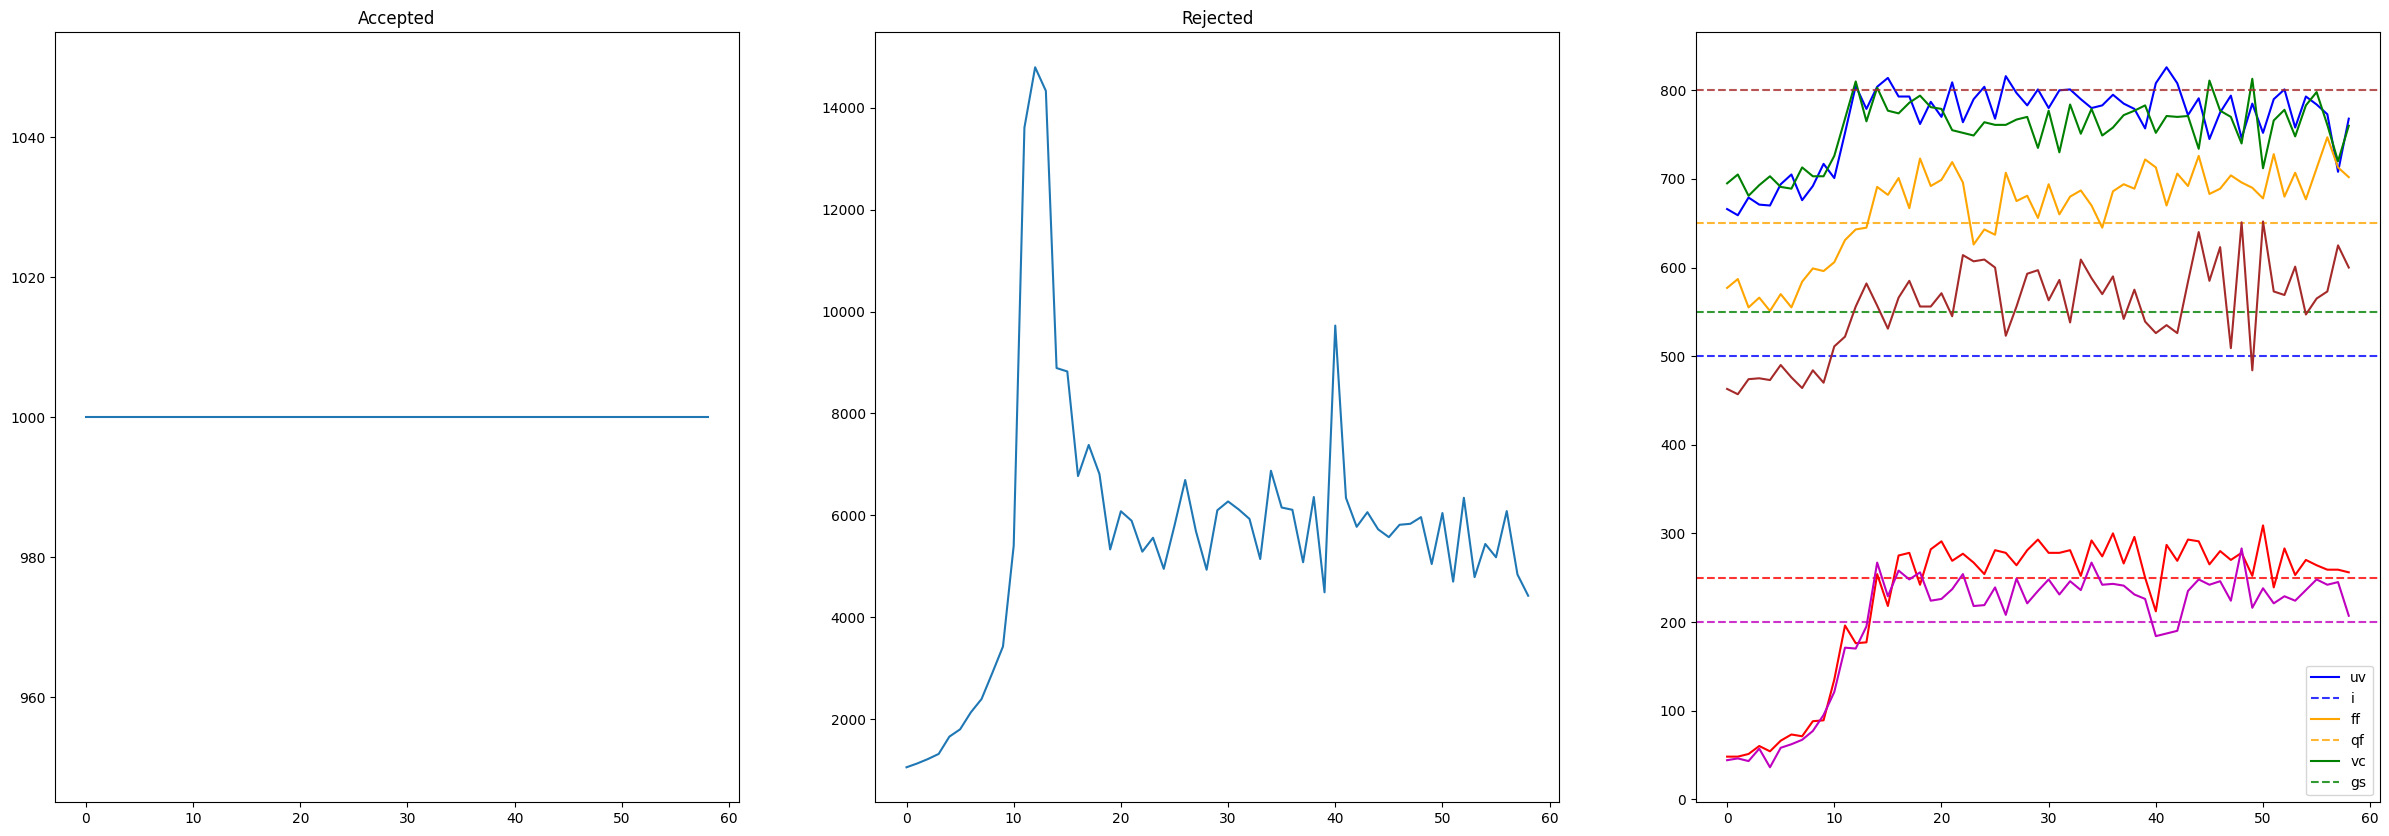

In [ ]:
# plot the accepted, rejected and cats accepted

accepted = np.array(model.get_env().get_attr('accepted_list'))

rejected = np.array(model.get_env().get_attr('rejected_list'))

cats_accepted = np.array(model.get_env().get_attr('accepted_cats_list'))[0]
# plot
plt.figure(figsize=(30, 5))
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(accepted[0])
axs[0].set_title('Accepted')
axs[1].plot(rejected[0])
axs[1].set_title('Rejected')
# 2D array, where rows have four columns, each column is its own line
if len(model.get_env().get_attr('cat_mins')) == 4:
  cat_to_color = {'tl': 'b', 'wc': 'orange', 'c': 'g', 'bl': 'r'}
  cat_to_min = {'tl': 650, 'wc': 450, 'c': 300, 'bl': 750}
  axs[2].plot(cats_accepted[0])
  axs[2].axhline(y=cat_to_min['tl'], color=cat_to_color['tl'], linestyle='--', alpha=0.3)
  axs[2].axhline(y=cat_to_min['wc'], color=cat_to_color['wc'], linestyle='--', alpha=0.3)
  axs[2].axhline(y=cat_to_min['c'], color=cat_to_color['c'], linestyle='--', alpha=0.3)
  axs[2].axhline(y=cat_to_min['bl'], color=cat_to_color['bl'], linestyle='--', alpha=0.3)
  axs[2].legend(['tl', 'wc', 'c', 'bl'])
  plt.show()
else:
  cat_to_color = [(cat, c) for cat, c in zip(categories, ['b', 'orange', 'g', 'r', 'm', 'brown'])]
  cat_to_min = {cat: cat_min for cat, cat_min in zip(categories, cat_mins)}
  for i in range(len(cat_to_color)):
    cat = cat_to_color[i][0]
    color = cat_to_color[i][1]
    line = axs[2].plot(cats_accepted[:, i], color=color)
    axs[2].axhline(y=cat_to_min[cat], color=color, linestyle='--', alpha=0.8)
  axs[2].legend(labels = categories)
  leg = axs[2].get_legend()
  plt.show()

In [ ]:
# get max value of rejected and its index
max_rejected = np.max(rejected)
max_rejected_index = np.argmax(rejected)
# get max value of accepted and its index
print(cats_accepted[0][max_rejected_index])
print(rejected[0][max_rejected_index])
print(accepted[0][max_rejected_index])

IndexError: index 12 is out of bounds for axis 0 with size 6

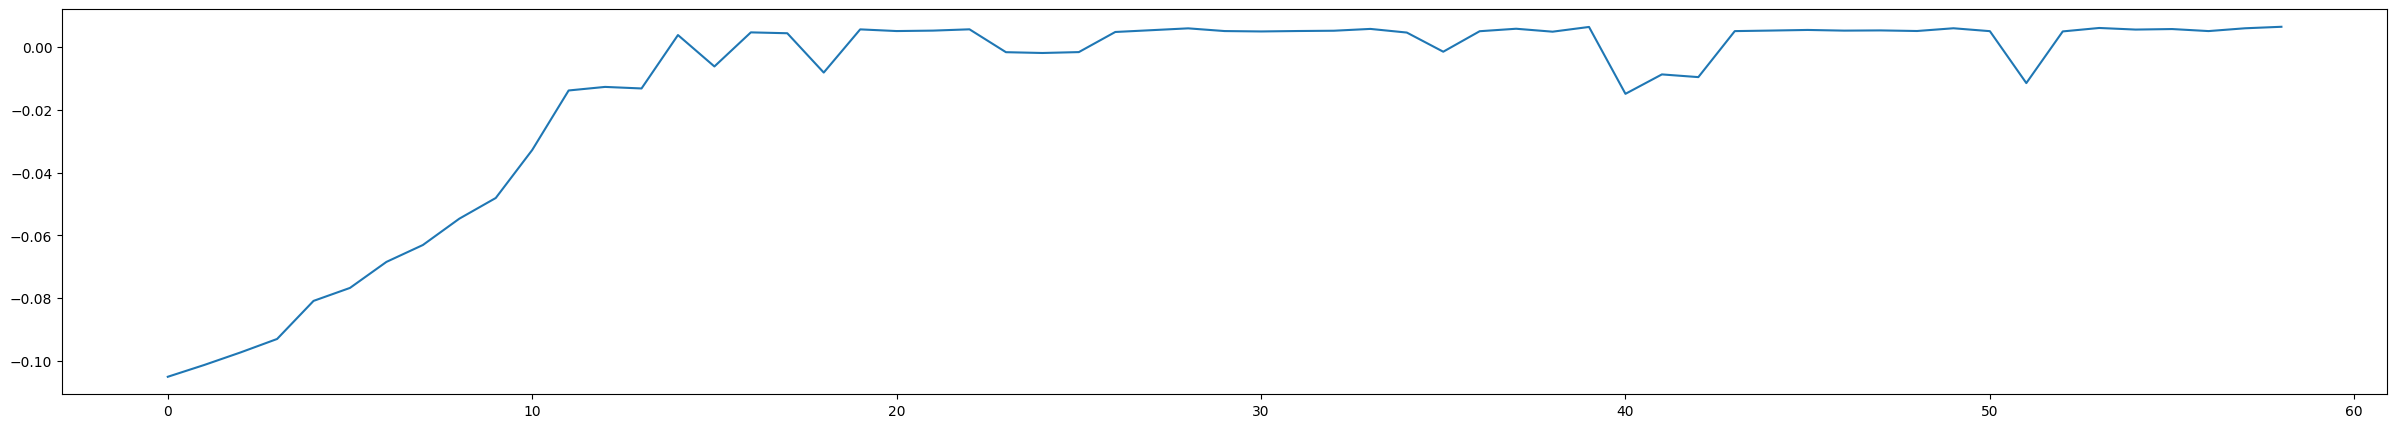

In [ ]:
# plot the shaping terms already gathered from vec_env
shaping_terms = np.array(model.get_env().get_attr('shaping_avgs')[0])
# plot the shaping terms
plt.figure(figsize=(30, 5))
# plt.plot(np.mean(shaping_terms.reshape(-1, 2), axis=-1))
plt.plot(shaping_terms)

0.13846979869069626
666


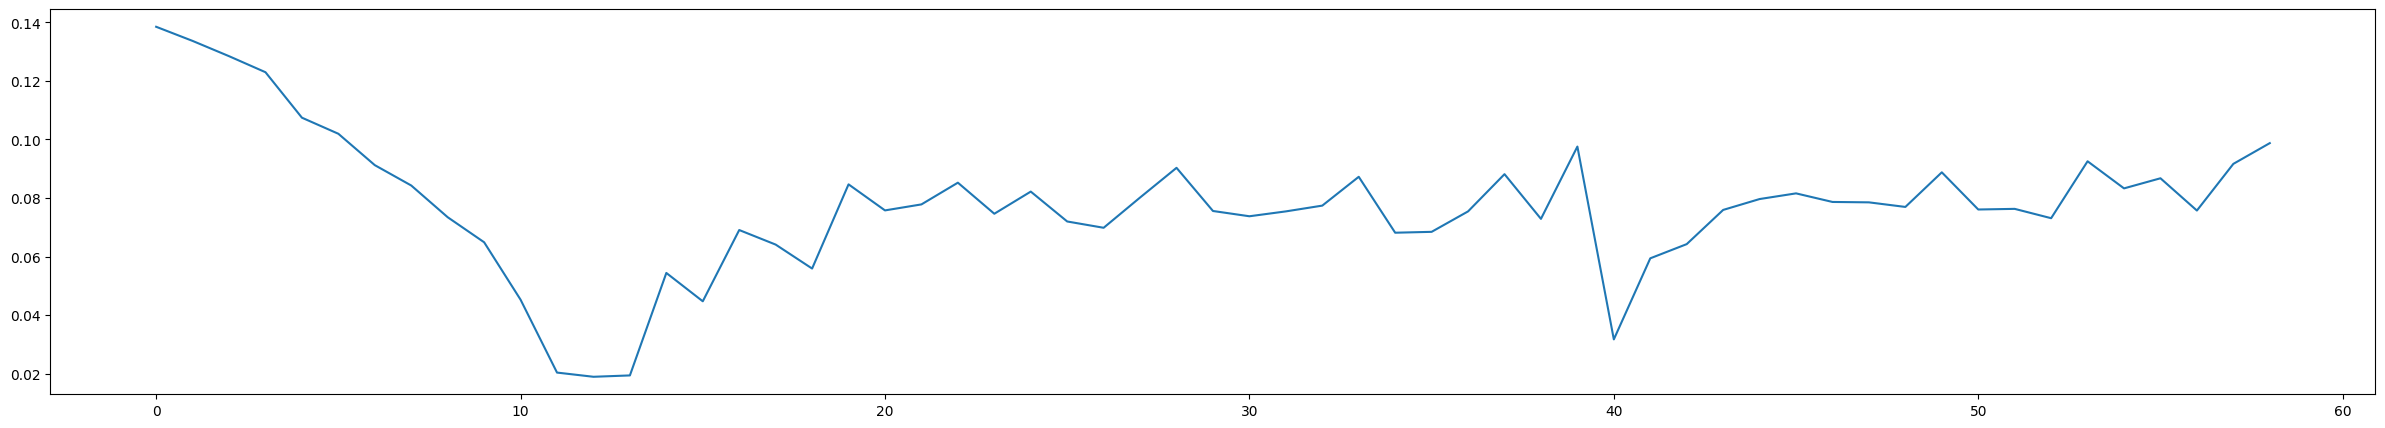

In [ ]:
# total rewards
total_rewards = np.array(model.get_env().get_attr('total_rewards_avgs')[0])
# plot the total rewards
plt.figure(figsize=(30, 5))
plt.plot(np.mean(total_rewards.reshape(-1, 1), axis=1))

max_rewards = np.max(total_rewards)
max_rewards_index = np.argmax(total_rewards)
print(max_rewards)
print(cats_accepted[0][max_rewards_index])

# Save if model is good

In [ ]:
save_path = "/content/drive/MyDrive/rl_stuff"
os.makedirs(save_path, exist_ok=True) # Create the folder if it doesn't exist

model_file_path = os.path.join(save_path, "bouncer_dqn_PBRS_goal_budget_only_st200k")

# 5. Save the model
model.save(model_file_path)
print(f"Model saved to {model_file_path}.zip")

Model saved to /content/drive/MyDrive/rl_stuff/bouncer_dqn_PBRS_goal_budget_only_st200k.zip


# Train from saved state

In [ ]:
# game_kwargs = {
#     "rel_frequencies": relative_frequencies,
#     "cat_mins": cat_mins,
#     "max_accepted": 1000,
#     "max_rejected": 20000,
#     "max_hardness": 1,
#     "max_hardness_completions": 1
# }

# # This is the breakthrough, tuning these parameters was key to provide good signals to the model
# # Tuning protocol: Closer to goal should provide higher rewards, furthest from goal should provide lowest, and to goal should provide highest
# reward_weights_kwargs = {
#     'rejection': 20.0,
#     'final_bonus': 100.0,
#     'final_penalty': -100.0,
#     'potential_shaping_scalar': 20.0, # Weight for the potential shaping term
#     'potential_discount_factor': 0.99999 # Discount factor for the potential shaping term
# }

game_kwargs = {
    "rel_frequencies": relative_frequencies,
    "cat_mins": cat_mins,
    "max_accepted": 1000,
    "max_rejected": 20000,
    "max_hardness": 1,
    "max_hardness_completions": 1
}

reward_weights_kwargs = {
    'level_granularity': 5,
    'rejection': 20.0,
    'cat_filled_bonus': 5.0,
    'final_bonus': 100.0,
    'final_penalty': -50.0,
    'potential_shaping_scalar': 10.0, # Weight for the potential shaping term
    'potential_discount_factor': 0.99999 # Discount factor for the potential shaping term
}

ENV_KWARGS = {
    "df": synthetic_df,
    "game_kwargs": game_kwargs,
    "reward_weights_kwargs": reward_weights_kwargs
}

 # train from saved state
save_path = "/content/drive/MyDrive/rl_stuff"
os.makedirs(save_path, exist_ok=True) # Create the folder if it doesn't exist
model_load_path = os.path.join(save_path, "bouncer_test_1")

# Load the model
n_envs = 4
n_steps = 2048*5
eval_freq = n_steps * n_envs
n_epochs = 10
total_timesteps = n_steps * n_epochs * n_envs
batch_size = 128

vec_env = make_vec_env(BouncerEnv, n_envs=n_envs, env_kwargs=ENV_KWARGS)
loaded_model = PPO.load(model_load_path, env=vec_env, kwargs={
    "n_steps": n_steps,
    "batch_size": batch_size,
    })
print("Model loaded successfully!")

# train the model
eval_callback = CustomEvalCallback(train_env=vec_env, verbose=0, eval_freq=eval_freq)
loaded_model.learn(total_timesteps=total_timesteps, progress_bar = False, callback=eval_callback, )
# save model
model_save_path = os.path.join(save_path, "bouncer_test_1_800k")
model.save(model_save_path)
print(f"Model saved to {model_file_path}.zip")

Model loaded successfully!
------------TRAIN LEVEL = 1 / 1------------
------------EVAL LEVEL = 1 / 1------------
Episode:0 
Score:-5.923020839691162
Terminal Observation:
    Fulfilled Categories: [0.9323077  1.         0.31666666 0.52      ]
    Accepted: [0.917]
    Rejected: [1.]
Succeeded: False


KeyboardInterrupt: 

Episode:0 
Score:-2017.9401502458718
Terminal Observation:
    Fulfilled Categories: [2464 2330  567 2014]
    Accepted: 4341
    Rejected: 5659
Succeeded: True
Episode:0 
Score:-2030.3000591641107
Terminal Observation:
    Fulfilled Categories: [2367 2297  579 2081]
    Accepted: 4221
    Rejected: 5779
Succeeded: True
Episode:0 
Score:-1977.6938693331972
Terminal Observation:
    Fulfilled Categories: [2915 2603  591 2255]
    Accepted: 4953
    Rejected: 5047
Succeeded: True
-----------------------------
| time/              |      |
|    fps             | 15   |
|    iterations      | 1    |
|    time_elapsed    | 129  |
|    total_timesteps | 2048 |
-----------------------------
Episode:0 
Score:-2010.8907738398154
Terminal Observation:
    Fulfilled Categories: [2310 2258  571 1996]
    Accepted: 4121
    Rejected: 5879
Succeeded: True
Episode:0 
Score:-2015.2487343214045
Terminal Observation:
    Fulfilled Categories: [2417 2148  573 1920]
    Accepted: 4155
    Rejected: 5845
S

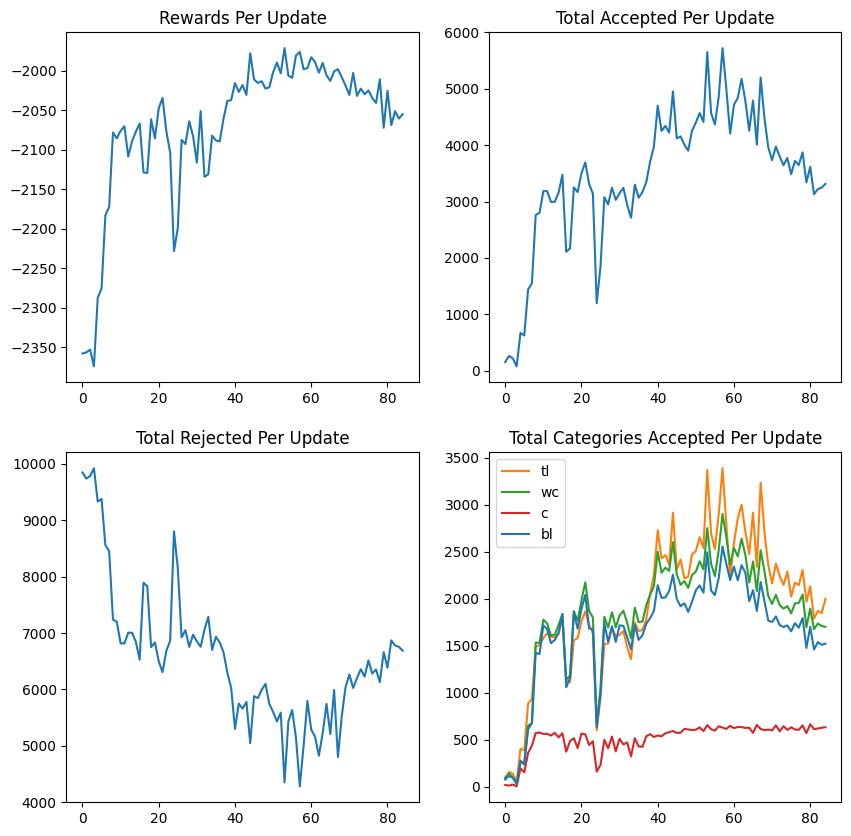

Model saved to /content/drive/MyDrive/rl_stuff/ll_puzzle_2_40.zip


In [ ]:
loaded_model.learn(total_timesteps=2049*20, progress_bar = False, callback=eval_callback, )

model_file_path = os.path.join(save_path, "ll_puzzle_2_40")

model.save(model_file_path)
print(f"Model saved to {model_file_path}.zip")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded successfully!
Episode:0 
Score:-2006.375074176702
Terminal Observation:
    Fulfilled Categories: [2546 2409  593 2115]
    Accepted: 4494
    Rejected: 5506
Succeeded: True
Episode:0 
Score:-1996.6546321372189
Terminal Observation:
    Fulfilled Categories: [2765 2492  564 2188]
    Accepted: 4705
    Rejected: 5295
Succeeded: True
Episode:0 
Score:-1954.445232462115
Terminal Observation:
    Fulfilled Categories: [3676 3025  568 2614]
    Accepted: 6057
    Rejected: 3943
Succeeded: True
-----------------------------
| time/              |      |
|    fps             | 15   |
|    iterations      | 1    |
|    time_elapsed    | 129  |
|    total_timesteps | 2048 |
-----------------------------
Episode:0 
Score:-2028.9648624375454
Terminal Observation:
    Fulfilled Categories: [2255 2215  572 1937]
    Accepted: 3992
    Rejected: 6008
Succeeded: True
Episode:0 
Score:-2013.7953191238716
Termina

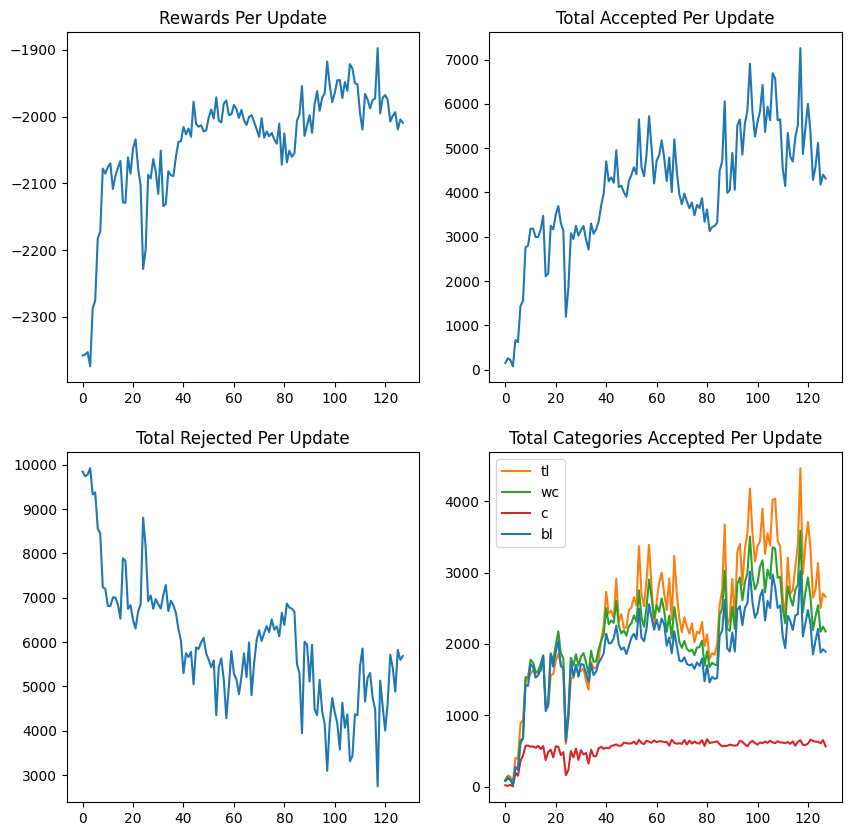

Model saved to /content/drive/MyDrive/rl_stuff/ll_puzzle_2_60.zip


In [ ]:
loaded_model = PPO.load(model_file_path, env=env)
print("Model loaded successfully!")

model_file_path = os.path.join(save_path, "ll_puzzle_2_60")

loaded_model.learn(total_timesteps=2049*20, progress_bar = False, callback=eval_callback, )

model.save(model_file_path)
print(f"Model saved to {model_file_path}.zip")

In [ ]:
list1 = [1, 1]
list2 = np.array([2, 2])
list1 - list2

array([-1, -1])

# Notes so far

Budget needs to play heavier role to signal to model when it is under budget (in a failing state), this way it knows how to come back from a failing state (impossible), or how to avoid this failing state.

Need to ensure rarity weights don't oversaturate "need to fill this category" so that it doesn't overpopulate too much late stage.

## Current setup:

Budget * 5.0

Rarity weight = 1.0

Penalty only for poor budget allocations

Rewards for goal approachment and good budget allocations

## Results:
    - Overpopulates rarest category, underpopulates category with most counts needed
    - High rejection counts at around 8000
    - Underpopulates largest cat, fully populates other categories
    - Unacceptable as is

## Hyperparameter Results:
    - Rarity exponent lower helps model overshoot less initially on rarity
      - Overshooting may imply letting model think more is better, and lower helps other categories fill out
    - Budget scale helps lower rejections and meet category minimums
      - These may be somewhat inversely correlate
    - Decent result settings:
      - rarity exponent = 0.5
      - Budget scale: 20.0
    - Allow budget to go negative:
      - TBD:

## Ideas to try

## Lower rarity weight (0.5)
  ### Results: TBD
    - Awesome, approaches goal even more so, implying that rarity weights were dominating a bit too much
    - Goal approachment is better
    - Rejections are lower
## Rarity weight (0.4)
    - Results are okay, though winning states seem to be less, rejections do seem to go down, however.




## Allow budget to go negative to indicate an overpopulation state

## Increase budget_scale
    - Results: Rarity weight = 0.5, budget_scale = 10
    - FIRST DUB LET'S GOOOOOOOOO, got it
    - Budget is an extremely good indicator to the model, did it in 4900 refusals

## Include sparse category fulfillment goals
    - Setting: rw = 0.5, budget_scale = 10, sgpb = 50
    - Results: Seems to have actually hindered progress (more rejections, less completions)

## Focusing on budget, increase max_budget_needed to provide stronger signals for losing states
    - (max_budget_needed > current_budget) implies losing state, can't possibly fill with current budget
    - Max budget needed from 2.0 -> 3.0
    - reward weight = 0.5
    - budget scale = 10.0
    - Made things worse

## Final method, keep tweaking budget_scale
    - Max budget needed from 2.0
    - reward weight = 0.5
    - budget scale = 20.0
    - Keeps getting better, and rejections keep going down

## Remove distance, focus on budget
    - Didn't even fucking need the distance
    - Still overshooting based on rarity, maybe ease the rarity weight a bit more
    - Performs well with rarity weight 0.4
    - Still overshoots